# **IMPORTS**

In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import warnings 

import matplotlib.pyplot as plt
from datetime import datetime

from IPython.display import HTML, display

from typing import Callable

from tqdm import tqdm

from pathlib import Path

root_to_data = Path('/kaggle/input/timeseries')


warnings.simplefilter('ignore')

data_columns = [
    'account_id', 'name', 
    'point', 'call_count', 
    'total_call_time', 'total_exclusive_time', 
    'min_call_time', 'max_call_time', 
    'sum_of_squares', 'instances', 
    'language', 'app_name', 
    'app_id', 'scope', 'host', 
    'display_host', 'pid', 
    'agent_version', 'labels'
]

delete_columns = ['agent_version', 'labels', 'account_id', 'name', 'language', 'app_name', 'app_id', 'host', 'display_host']

# **DATA**

In [2]:
def load_data():
    data_columns = [
        'account_id', 'name', 'point', 'call_count', 'total_call_time', 'total_exclusive_time', 'min_call_time', 'max_call_time', 'sum_of_squares', 'instances', 'language', 'app_name', 'app_id', 'scope', 'host', 'display_host', 'pid', 'agent_version', 'labels'
    ]

    df = pd.read_csv(f'{root_to_data}/dict_data.csv', sep='\t', names=data_columns)
    df = df.fillna('')

    return df


def base_proect(df: pd.DataFrame, proect_fun: Callable):
    list_of_data = df.to_dict('records')

    res_list = []
    for data in list_of_data:
        time = data['point']
        time = datetime.strptime(time, '%Y-%m-%d %H:%M:%S')

        timestamp = int(time.timestamp())
        value = proect_fun(data)
        if value is None:
            continue

        res_list.append(
            {timestamp: value}
        )

    return res_list


def web_response(data: dict):
    check = data['language'] == 'java' and data['app_name'] == '[GMonit] Collector' and data['scope'] == '' and data['name'] == 'HttpDispatcher'
    if not check:
        return None

    total_call_time = data['total_call_time']
    call_count = data['call_count']
    if total_call_time and call_count:
        return total_call_time / call_count
    else:
        return 0


def throughput(data: dict):
    check = data['language'] == 'java' and data['app_name'] == '[GMonit] Collector' and data['scope'] == '' and data['name'] == 'HttpDispatcher'
    if not check:
        return None

    call_count = data['call_count']
    if call_count:
        return call_count
    else:
        return 0


def apdex(data: dict):
    check = data['language'] == 'java' and data['app_name'] == '[GMonit] Collector' and data['scope'] == '' and data['name'] == 'Apdex'
    if not check:
        return None

    s = data['call_count']
    t = data['total_call_time']
    f = data['total_exclusive_time']

    if s and t and f:
        return (s + t/2) / (s + t + f)
    else:
        return 0


In [3]:
df = load_data()
web_response_list = base_proect(df, web_response)
throughput_list = base_proect(df, throughput)
apdex_list = base_proect(df, apdex)

print(df.shape, '\n', df.head(3))

(300, 19) 
    account_id            name                point  call_count  \
0           1  HttpDispatcher  2024-05-13 00:58:00      1317.5   
1           1  HttpDispatcher  2024-05-13 00:59:00      2624.5   
2           1  HttpDispatcher  2024-05-13 01:00:00      2654.5   

   total_call_time  total_exclusive_time  min_call_time  max_call_time  \
0        10.690983             10.690983       0.000123       1.071242   
1        20.925472             20.925472       0.000123       1.584442   
2        20.345570             20.345570       0.000116       1.584442   

   sum_of_squares  instances language            app_name          app_id  \
0        1.777954        0.5     java  [GMonit] Collector  17592186045423   
1        4.312097        1.0     java  [GMonit] Collector  17592186045423   
2        4.929003        1.0     java  [GMonit] Collector  17592186045423   

  scope          host  display_host  pid agent_version labels  
0        575f5ba20b4b  575f5ba20b4b    1         8.5.

In [4]:
def make_plot_timestamp_value(timestamps : list, values : list):
    plt.figure(figsize=(10, 5))
    plt.plot(timestamps, values, marker='o', linestyle='-', color='b')
    plt.title('Все временные метки')
    plt.xlabel('Дата')
    plt.ylabel('Значение')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



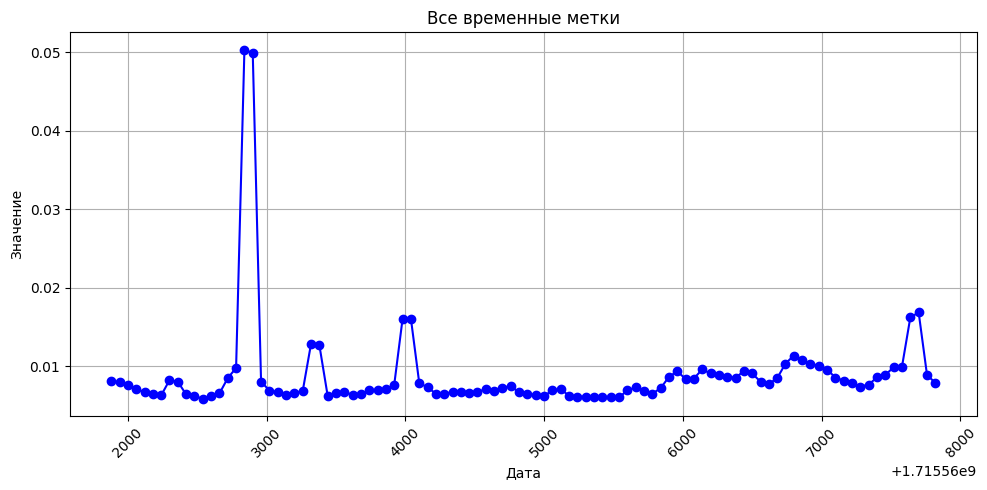


timestamps: 80
values: [0.008114598102466793, 0.007973127071823204, 0.007664558297231117, 0.007087347110600843, 0.006725938184663536, 0.006472355278535256, 0.006288141341341341, 0.008229183912691996, 0.008034436370855668, 0.006406580684104628, 0.006173725530599629, 0.0058882915569953434, 0.00622366766050487, 0.006538587285570131, 0.00849004903386661, 0.009784078630310717, 0.05029897925311203, 0.049881457307060756, 0.00805114008097166, 0.006906205700617899, 0.006662783729359646, 0.006331191080196399, 0.00663993777423215, 0.006822190719622493, 0.012834749748339038, 0.01271375641815568, 0.006245225607245781, 0.006656724495790091, 0.006715710144927536, 0.006366341759749167, 0.00643178668012109, 0.006994884206219313, 0.00693469451697128, 0.007080383683360259, 0.0076673240279162514, 0.016030704738760632, 0.016063519920318726, 0.007890855614973262, 0.007302320015293443, 0.006522516669916163, 0.006429283064033513, 0.00678005035971223, 0.006767599919500905, 0.006565360579826858, 0.006683706358

In [16]:
%%time 
# исходные данные
timestamps = [list(entry.keys())[0] for entry in web_response_list] 
values = [list(entry.values())[0] for entry in web_response_list] 

make_plot_timestamp_value(timestamps, values)
print()
print(f'timestamps: {len(timestamps[:80])}\nvalues: {values}')

# **MODEL**

In [6]:
class TimeSeriesDataset(Dataset):
    '''
    class: Датасет с временными метками и значениями в них
    '''
    def __init__(self, timestamps, values):
        self.timestamps = timestamps
        self.values = values

    def __len__(self):
        return len(self.values)

    def __getitem__(self, id_):
        return self.timestamps[id_], self.values[id_]

In [31]:
class TimeSeriesAnomalyDetector:
    '''
    class: Детекция аномалий во временных рядах
    '''
    def __init__(self, model_name: str):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.model.to(self.device)

        # Дополнительные слои для обнаружения аномалий
        self.fc1 = nn.Linear(self.model.config.hidden_size, 128).to(self.device)
        self.fc2 = nn.Linear(128, 1).to(self.device)  
        self.mse_loss = nn.MSELoss()
        self.optimizer = torch.optim.Adam(
            list(self.model.parameters()) + list(self.fc1.parameters()) + list(self.fc2.parameters()), 
            lr=1e-5
        )

    def preprocess(self, timestamps, values):
        # Соединяем временные метки и значения в одну строку
        time_series = [f"{ts}:{val}" for ts, val in zip(timestamps, values)]
        inputs = self.tokenizer(time_series, return_tensors='pt', padding=True, truncation=True)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        return inputs, torch.tensor(values, dtype=torch.float32).to(self.device).unsqueeze(-1)

    def forward(self, inputs):
        outputs = self.model(**inputs)
        hidden_states = outputs.last_hidden_state
        x = torch.relu(self.fc1(hidden_states[:, 0, :]))
        reconstructions = self.fc2(x)
        return reconstructions

    def train(self, train_loader, epochs=3):
        self.model.train()
        for epoch in tqdm(range(epochs)):
            total_loss = 0
            for batch in train_loader:
                timestamps, values = batch

                timestamps = [timestamp for timestamp in timestamps]
                values = [value.item() if isinstance(value, torch.Tensor) else value for value in values]

                inputs, targets = self.preprocess(timestamps, values)

                self.optimizer.zero_grad()
                reconstructions = self.forward(inputs)
                loss = self.mse_loss(reconstructions, targets)
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader)}")


    def predict(self, timestamps, values):
        self.model.eval()
        with torch.no_grad():
            inputs, _ = self.preprocess(timestamps, values)
            reconstructions = self.forward(inputs)
            reconstruction_error = torch.mean((reconstructions - torch.tensor(values, dtype=torch.float32).to(self.device).unsqueeze(-1)) ** 2, dim=1).cpu().numpy()

            threshold = 0.5 
            probabilities = reconstruction_error / max(reconstruction_error) 
            anomalies = probabilities > threshold

            return reconstruction_error, probabilities, anomalies

    def detect_anomaly_intervals(self, anomalies):
        anomaly_intervals = []
        start = None
        for i, is_anomaly in enumerate(anomalies):
            if is_anomaly and start is None:
                start = i
            elif not is_anomaly and start is not None:
                anomaly_intervals.append((start, i - 1))
                start = None
        if start is not None:
            anomaly_intervals.append((start, len(anomalies) - 1))
        return anomaly_intervals

In [32]:
dataset = TimeSeriesDataset(timestamps[:80], values[:80])
train_loader = DataLoader(dataset, batch_size=2, shuffle=True)

model_name = 'bert-base-uncased'
anomaly_detector = TimeSeriesAnomalyDetector(model_name)

# Train the model
anomaly_detector.train(train_loader)

 33%|███▎      | 1/3 [00:02<00:05,  2.53s/it]

Epoch 1/3, Loss: 0.0011681166082325944


 67%|██████▋   | 2/3 [00:05<00:02,  2.54s/it]

Epoch 2/3, Loss: 0.0006650195943770143


100%|██████████| 3/3 [00:07<00:00,  2.53s/it]

Epoch 3/3, Loss: 0.000481467474838837


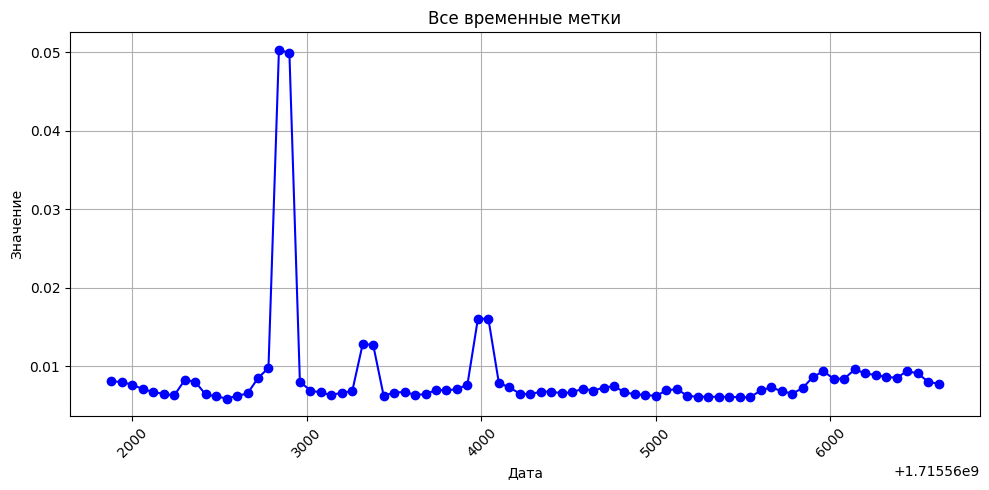

Reconstruction Error: [4.1151667e-05 3.3224554e-05 1.6485696e-05 1.4642700e-05 1.4779067e-05
 1.3947905e-06 1.9932759e-05 1.0941244e-05 9.8075952e-07 3.4159943e-06
 2.0025486e-06 1.5793503e-06 1.8030618e-06 1.2678280e-05 1.2577924e-05
 2.1038726e-05 1.8309238e-03 1.7504311e-03 1.2525626e-07 3.6391421e-07
 8.2692316e-07 2.4671283e-06 4.9808732e-06 3.9024897e-05 3.0141669e-05
 4.6384805e-05 2.7191634e-06 3.3142306e-10 4.7657841e-06 5.7921028e-07
 1.9648714e-06 4.9893256e-06 2.6250812e-06 1.8140822e-06 3.2624325e-06
 8.9554203e-05 9.4530398e-05 2.2668975e-05 2.3452041e-05 3.3851293e-07
 1.9720228e-06 1.1327051e-05 1.2075380e-05 7.8305256e-08 4.0537166e-06
 2.9342744e-05 2.8084148e-06 1.5336695e-05 1.9049152e-05 5.0647702e-07
 4.2560964e-06 7.1601357e-06 8.0181226e-06 1.0578655e-05 6.3429725e-06
 1.8526896e-06 1.0781248e-05 9.2349665e-06 5.2565088e-07 2.3305906e-06
 5.1263391e-06 2.7389241e-08 1.2306644e-05 4.1572574e-05 4.3772147e-06
 1.0461882e-07 1.1057650e-05 1.4409312e-05 2.3872946e-0

In [33]:
timestamps_test = timestamps[:-20]
values_test = values[:-20]
reconstruction_error, probabilities, anomalies = anomaly_detector.predict(timestamps_test, values_test)

make_plot_timestamp_value(timestamps_test, values_test)

print("Reconstruction Error:", reconstruction_error)
print("Probabilities:", probabilities)
print("Anomalies:", anomalies)

anomaly_intervals = anomaly_detector.detect_anomaly_intervals(anomalies)
print("Anomaly Intervals:", anomaly_intervals)